Funkcja sklejana 3 stopnia

In [2]:
using Plots
using Polynomials
using LinearAlgebra

gr()

Plots.GRBackend()

In [1]:
function Spline(x, y,f)
    n = length(x)
    a = zeros(Float64, n)
    
    function F(n)
        return [exp((2pi*im/n)*j*k) for j=0:n-1, k=0:n-1]
    end
    function Natural(n, x, y)
        h = zeros(Float64, n-1)
        b = zeros(Float64, n-1)

        for i = 1:(n-1)
            h[i] = x[i+1]-x[i]
            b[i] = 6*(y[i+1]-y[i])/h[i]
        end
        
        u = zeros(Float64, n-1)
        v = zeros(Float64, n-1)
        u[2] = 2*(h[1]+h[2])

        v[2] = b[2]-b[1]
        
        for i = 3:(n-1)
            u[i] = 2*(h[i-1]+h[i]) - h[i-1]^2/u[i-1]
            v[i] = b[i] - b[i-1] - h[i-1]*v[i-1]/u[i-1]
        end
        z = zeros(Float64,n)
        z[n] = 0
        for i in (n-1):-1:1
            
            z[i] = (v[i]-h[i]*z[i+1])/u[i]
        end
        z[1] = 0
        return h,z
    end
    function Periodic(n, x, y)
        z = zeros(Float64, n-1, 1)
        M = zeros(Float64, n-1, n-1)
        v = zeros(Float64, n-1, 1)
        zf = zeros(Float64, n, 1)
        h = zeros(Float64, n-1)

        for i = 1:(n-1)
            h[i] = x[i+1]-x[i]
        end
        #hidden assumption here: step of t_i is 1
        M[1, 1] = 2/3
        M[1, 2] = 1/6
        M[1, n-1] = 1/6
        M[n-1, 1] = 1/6
        M[n-1, n-2] = 1/6
        M[n-1, n-1] = 2/3


        for i = 1:n-2
            v[i,1] = y[i]+y[i+2]-2*y[i+1]
        end
        v[n-2, 1] = y[n-2]+y[n]-2*y[n-1]
        v[n-1, 1] = y[n-1]+y[2]-2*y[n]
        

        for i=2:(n-2)
            M[i, i-1] = 1/6
            M[i,i] = 2/3
            M[i, i+1] = 1/6


        end
        
        z = M\v
        fourier = F(n-1)
        eigenvalues = fourier * M[1,:]
        z2 = real((fourier * ((Diagonal(eigenvalues .^(-1))) * ((conj(fourier) * v))) /(n-1)))
        #print(z .- z2)
        for i = 2:n
            zf[i]=z2[i-1]
        end
        zf[1]=zf[n]
        return h, zf
    end
    h = 0
    z = 0

    h, z = Periodic(n, x, y)
    #h, z = Natural(n, x, y)
    function FindParameters(n, h, z, y)
        S = zeros(Float64, n-1, 3)
        for i = 1:(n-1)
            S[i,1] = (z[i+1]-z[i])/6
            S[i,2] = z[i]/2
            S[i,3] = -1*h[i]*(z[i+1]+2*z[i])/6+(y[i+1]-y[i])/h[i]
        end
        return S
    end
    S = FindParameters(n, h, z, y)
    function ChangePolynomialForm(n, x, y, S)
        P = zeros(Float64, n-1, 4)
        for i = 1:(n-1)
            P[i,1] = S[i,1]
            P[i,2] = S[i,2]-3*S[i,1]*x[i]
            P[i,3] = 3*S[i,1]*(x[i]^2)-2*S[i,2]*x[i]+S[i,3]
            P[i,4] = -1*S[i,1]*(x[i]^3)+S[i,2]*(x[i]^2)-S[i,3]*x[i]+y[i]
        end
        return P
    end
    
    if(f===2)
        return ChangePolynomialForm(n,x,y,S)
    end
    return S
end


Spline (generic function with 1 method)

In [3]:
function Graph(coeffs, x, n, density=30)
    ps = Polynomial(reverse(coeffs[1,:]))
    xs = LinRange(x[1], x[2], density)
    plot(xs, ps.(xs),legend=false, xlabel="t", ylabel="s(t)")
    for i = 2:(n-1)
    
        ps = Polynomial(reverse(coeffs[i,:]))
        xs = LinRange(x[i], x[i+1], density)
        plot!(xs, ps.(xs),legend=false)
        
    end
    current()
end


Graph (generic function with 2 methods)

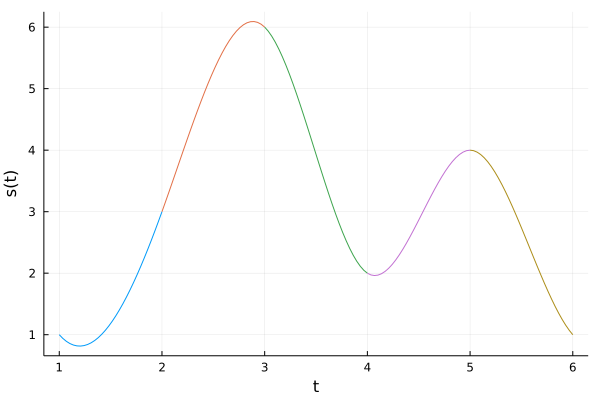

In [4]:
x = (Float64)[1, 2, 3, 4, 5, 6]
y = (Float64)[1, 3, 6, 2, 4, 1]
n = length(x)
coeffs=Spline(x,y,2)

Graph(coeffs, x, n)

In [5]:
coeffs

5×4 Matrix{Float64}:
 -1.27273    9.0      -16.0909     9.36364
 -3.0       19.3636   -36.8182    23.1818
  5.27273  -55.0909   186.545   -200.182
 -5.09091   69.2727  -310.909    463.091
  4.09091  -68.4545   377.727   -684.636

In [52]:
function Ellipse(a, b, omega=1)
    return t -> a * cos.(t*omega), t -> b * sin.(t*omega)
end

function GenerateNodes(curve, ts)
    
    return curve[1].(ts), curve[2].(ts)
end

function GraphCurve(coeffs1, coeffs2, t, n, density=30)
    ps1 = Polynomial(reverse(coeffs1[1,:]))
    ps2 = Polynomial(reverse(coeffs2[1,:]))
    ts = LinRange(t[1], t[2], density)
    #print(ps1.(ts))
    plot(ps1.(ts), ps2.(ts),legend=false,aspect_ratio=:equal, xlabel="x", ylabel="y")
    for i = 2:(n-1)
        ps1 = Polynomial(reverse(coeffs1[i,:]))
        ps2 = Polynomial(reverse(coeffs2[i,:]))
        ts = LinRange(t[i], t[i+1], density)
        plot!(ps1.(ts), ps2.(ts),legend=false,aspect_ratio=:equal)
        
    end
    current()
end
function MSE(curve, coeffs1, coeffs2, t, n, density=30)
    err = 0.0
    for i = 1:(n-1)
        ps1 = Polynomial(reverse(coeffs1[i,:]))
        ps2 = Polynomial(reverse(coeffs2[i,:]))
        ts = LinRange(t[i], t[i+1], density)
        
        err = err + sum((ps1.(ts)-curve[1].(ts)) .^2 + (ps2.(ts)-curve[2].(ts)).^2) 
    end
    return err/(density*n) 
end

MSE (generic function with 2 methods)

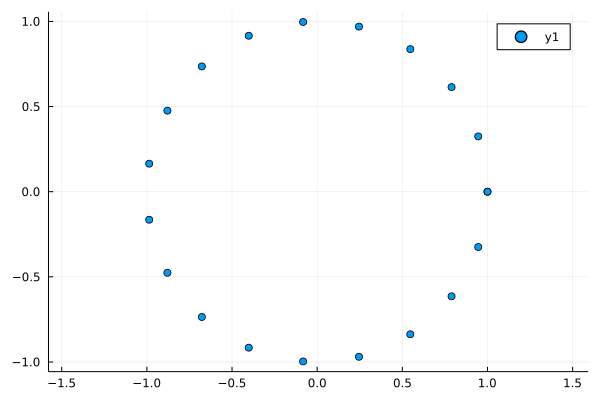

In [60]:
circle = Ellipse(1, 1, pi/10)

ts = collect(LinRange(0, 20, 20))

curveNodes = GenerateNodes(circle, ts)

coeffs1 = Spline(ts, curveNodes[1], 2)
coeffs2 = Spline(ts, curveNodes[2], 2)

scatter(curveNodes[1], curveNodes[2], aspect_ratio=:equal)


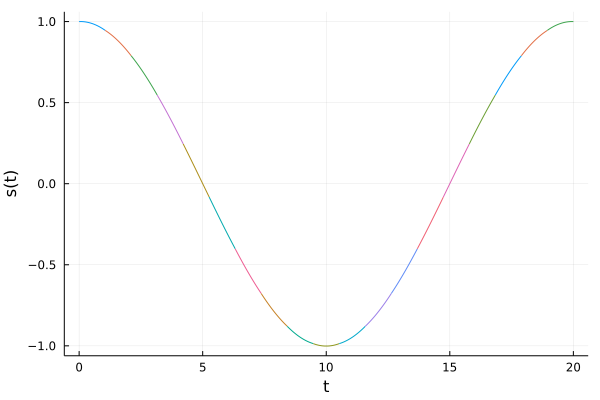

In [46]:
Graph(coeffs1, ts, 20)

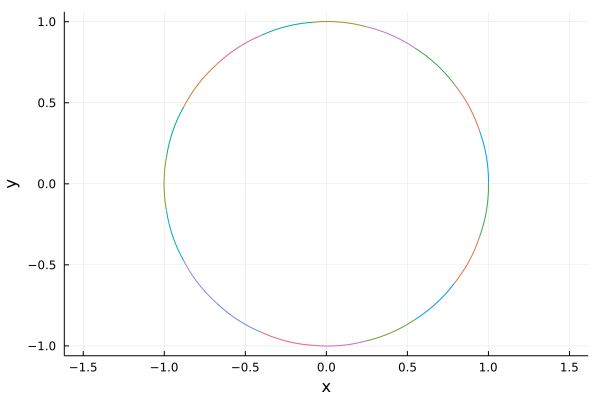

In [54]:
GraphCurve(coeffs1, coeffs2, ts, 20)

In [15]:
MSE(circle, coeffs1, coeffs2, ts, 20)

4.166919777396088e-6

In [62]:
sqrt(MSE(circle, coeffs1, coeffs2, ts, 20))

0.0010172307276698463

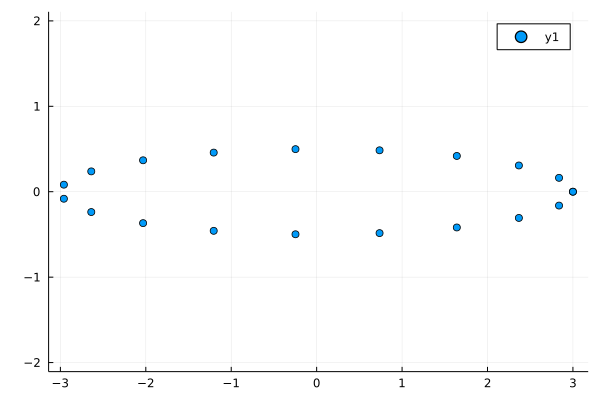

In [58]:
el = Ellipse(3, 0.5, pi/10)

ts = collect(LinRange(0, 20, 20))

curveNodes = GenerateNodes(el, ts)

coeffs1 = Spline(ts, curveNodes[1], 2)
coeffs2 = Spline(ts, curveNodes[2], 2)
scatter(curveNodes[1], curveNodes[2], aspect_ratio=:equal)

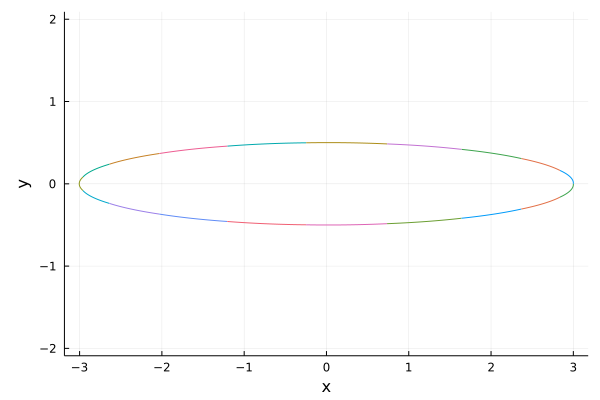

In [21]:
GraphCurve(coeffs1, coeffs2, ts, 20)

In [22]:
MSE(el, coeffs1, coeffs2, ts, 20)

4.785757384082456e-6

In [59]:
sqrt(MSE(el, coeffs1, coeffs2, ts, 20))

0.0021876373977609853

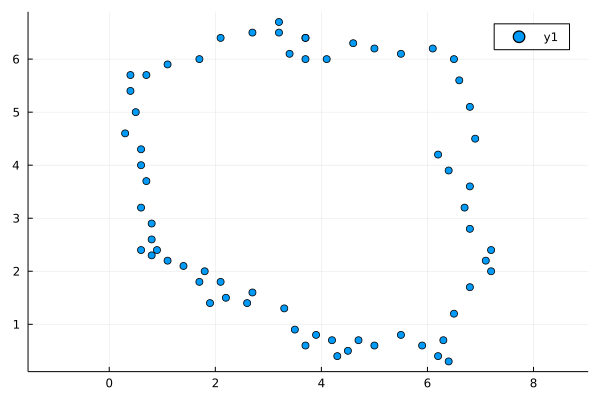

In [23]:
curveNodes = ([3.7, 3.2, 2.7, 2.1, 1.7, 1.1, 0.7, 0.4, 0.4, 0.5, 
0.3, 0.6, 0.6, 0.7, 0.6, 0.8, 0.8, 0.6, 0.8, 0.9,
1.1, 1.4, 1.8, 1.7, 1.9, 2.2, 2.1, 2.7, 2.6, 3.3,
3.5, 3.7, 3.9, 4.2, 4.3, 4.5, 4.7, 5.0, 5.5, 5.9,
6.2, 6.4, 6.3, 6.5, 6.8, 7.2, 7.1, 7.2, 6.8, 6.7,
6.8, 6.4, 6.2, 6.9, 6.8, 6.6, 6.5, 6.1, 5.5, 5.0, 
4.6, 4.1, 3.7, 3.4, 3.2, 3.7],[6.4, 6.7, 6.5, 6.4, 6.0, 5.9, 5.7, 5.7,
5.4, 5.0, 4.6, 4.3, 4.0, 3.7, 3.2, 2.9,
2.6, 2.4, 2.3, 2.4, 2.2, 2.1, 2.0, 1.8,
1.4, 1.5, 1.8, 1.6, 1.4, 1.3, 0.9, 0.6,
0.8, 0.7, 0.4, 0.5, 0.7, 0.6, 0.8, 0.6,
0.4, 0.3, 0.7, 1.2, 1.7, 2.0, 2.2, 2.4,
2.8, 3.2, 3.6, 3.9, 4.2, 4.5, 5.1, 5.6,
6.0, 6.2, 6.1, 6.2, 6.3, 6.0, 6.0, 6.1,
6.5, 6.4])#66
ts = collect(LinRange(0, 66, 66))

coeffs1 = Spline(ts, curveNodes[1], 2)
coeffs2 = Spline(ts, curveNodes[2], 2)
scatter(curveNodes[1], curveNodes[2], aspect_ratio=:equal)

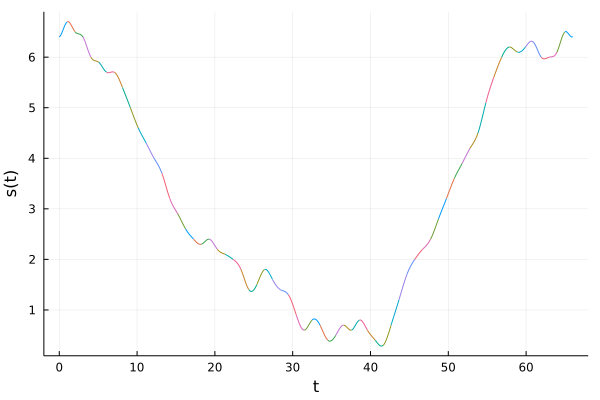

In [24]:
Graph(coeffs2, ts, 66)

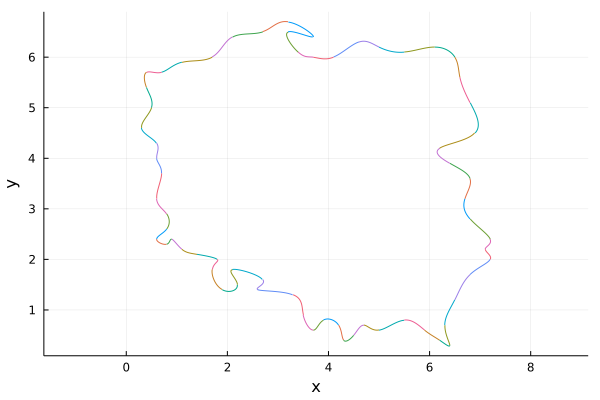

In [25]:
GraphCurve(coeffs1, coeffs2, ts, 66)

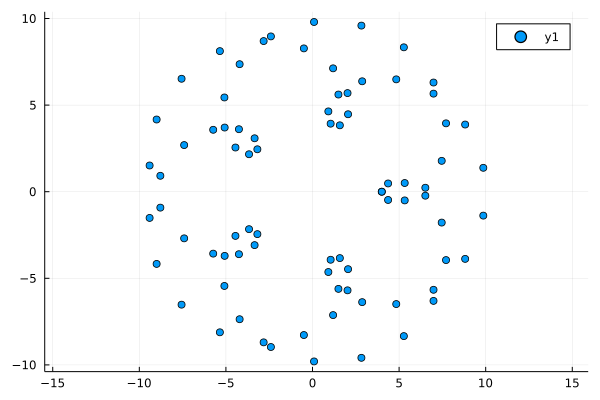

In [56]:
function Epitrochoid(R, r, h, omega=1)
    return t -> (R+r) * cos.(t*omega) - h * cos.(omega*(R+r)*t/r), t -> (R+r) * sin.(t*omega) - h * sin.(omega*(R+r)*t/r)
end
ep = Epitrochoid(5, 2, 3, pi/20)

ts = collect(LinRange(0, 80, 80))

curveNodes = GenerateNodes(ep, ts)

coeffs1 = Spline(ts, curveNodes[1], 2)
coeffs2 = Spline(ts, curveNodes[2], 2)
scatter(curveNodes[1], curveNodes[2], aspect_ratio=:equal)

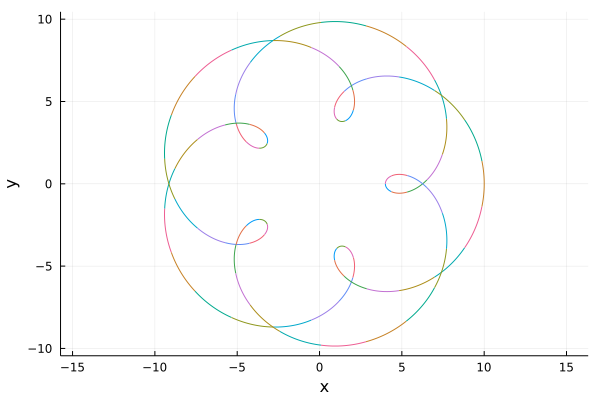

In [37]:
GraphCurve(coeffs1, coeffs2, ts, 80)

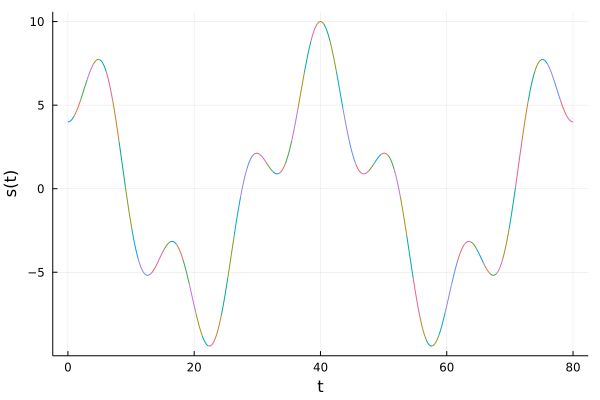

In [38]:
Graph(coeffs1, ts, 80)

In [39]:
MSE(ep, coeffs1, coeffs2, ts, 80)

2.82405349440629e-6

In [57]:
sqrt(MSE(ep, coeffs1, coeffs2, ts, 80))

0.0016804920393760543